<a href="https://colab.research.google.com/github/abstractguy/lstm_autoencoder_classifier/blob/master/LSTM_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Autoencoder for Rare Event Binary Classification

This is a continuation of the regular autoencoder for rare event classification presented in
https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
and code present in
https://github.com/cran2367/autoencoder_classifier/blob/master/autoencoder_classifier.ipynb
Here we will show an implementation of building a binary classifier using LSTM Autoencoders. 
Similar to the previous post, the purpose is to show the implementation steps. The Autoencoder tuning for performance improvement can be done.

LSTM requires closer attention to preparing the data. Here we have all the steps, and few tests to validate the data preparation.

The dataset used here is taken from here,

**Dataset: Rare Event Classification in Multivariate Time Series** https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

In [0]:
# Hardcode non-shared parameters.
AI = 'LSTM_autoencoder'
main_ticker = 'FB'
tickers_list = ['GE', 'ADS', 'INTC', 'AAPL', 'NVDA', 'CSCO', 'AMD', 'AMZN', 'GOOG', 'MSFT', 'S', 'BAC', 'XLNX', 'WFC', '^DJI', '^GSPC', '^NYA', '^IXIC']
unit_scaler = 3.4
length = 9
random_seed = 123 # Used to help randomly select the data points.
test_size = 0.2
gain = 0.0555
lookback = 5 # Equivalent to 5 days of past data.

In [0]:
# Hardcode shared parameters.
if AI == 'LSTM':
    trends = True
    batch_size = 64
    epochs = 200
    learning_rate = 0.0000013
    patience = 5

elif AI == 'LSTM_autoencoder':
    trends = True
    batch_size = 32
    epochs = 200
    learning_rate = 0.00008
    patience = 10

In [3]:
!pip install pytrends

In [4]:
%matplotlib inline

from collections import OrderedDict
from math import sqrt
from os import chdir
from os.path import exists
from datetime import datetime
from tqdm import tqdm
from numpy.random import seed
from numpy import append, array, concatenate, count_nonzero, empty, empty_like, expand_dims, mean, nan, power, var, where, zeros
from pandas import concat, DataFrame, date_range, read_csv, Series
from pandas_datareader.data import DataReader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import auc, classification_report, confusion_matrix, f1_score, mean_squared_error, precision_recall_curve, precision_recall_fscore_support, recall_score, roc_curve
from tensorflow import set_random_seed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Dropout, LeakyReLU, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, TerminateOnNaN
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import optimizers, Sequential
from google.colab.drive import mount
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from pytrends.request import TrendReq
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
path = '/content/gdrive/'
mount(path)
path = path + 'My Drive/LSTM_autoencoder/'
chdir(path)

In [0]:
seed(7)
set_random_seed(11)
rcParams['figure.figsize'] = 8, 6
labels = ['Normal', 'Break']

In [0]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(dataset, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    dataset  A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    dataset  A dataframe with the binary labels shifted by shift.
    '''
    vector = dataset.y.copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the DataFrame.
    dataset.insert(loc=0, column=labelcol + 'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    dataset = dataset.drop(dataset[dataset[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol.
    dataset = dataset.drop(labelcol, axis=1)
    dataset = dataset.rename(columns={labelcol + 'tmp': labelcol})
    # Make the labelcol binary.
    dataset.loc[dataset[labelcol] > 0, labelcol] = 1

    return dataset

def add_ticker_to_tickers(symbol, ticker, tickers):
    minimum_date = ticker.index.min()
    overall_minimum_date = tickers.index.min()
    if minimum_date > overall_minimum_date:
        start = overall_minimum_date
        tickers = tickers[tickers.index >= minimum_date]

    tickers[symbol][tickers.index.isin(ticker.index)] = ticker

    return tickers

def get_stock(main_ticker, tickers_list, path=path, trends=True):
    csv_path = path + 'dataset.csv'

    if exists(csv_path):
        tickers = read_csv(csv_path)
    else:
        start = datetime(1970, 1, 1)
        end = datetime.now()
        dates = date_range(start=start, end=end)

        main_ticker_y = main_ticker + '_y'
        tickers_list = [main_ticker] + tickers_list
        tickers_list = list(OrderedDict((ticker, True) for ticker in tickers_list).keys())

        columns = (tickers_list + [(symbol + '_trend') for symbol in tickers_list]) if trends else tickers_list
        columns = [main_ticker_y] + columns

        tickers = DataFrame(nan, index=dates, columns=columns)
        tickers.index.name = 'Date'

        if trends:
            pytrends = TrendReq(hl='en-US', tz=360)

        ticker = DataReader(main_ticker, 'yahoo', start=start, end=end)
        ticker_y = (ticker.Close / ticker.Open).dropna()
        tickers = add_ticker_to_tickers(main_ticker_y, ticker_y, tickers)

        for symbol in tqdm(tickers_list, unit='symbol'):
            try:
                ticker = DataReader(symbol, 'yahoo', start=start, end=end)
                ticker_X = (ticker.Close - ticker.Open).dropna()
                tickers = add_ticker_to_tickers(symbol, ticker_X, tickers)

                if trends:
                    pytrends.build_payload([symbol], timeframe='today 5-y')
                    ticker = pytrends.interest_over_time()[symbol]
                    tickers = add_ticker_to_tickers(symbol + '_trend', ticker, tickers)

            except:
                pass

        tickers = tickers.fillna(method='backfill').dropna()

        tickers.to_csv(csv_path)

    return tickers

def delta_time_series(data):
    return data[1:] - data[:-1]

def plot_dataset(dataset):
    plt.plot(dataset)
    plt.xlabel('Days')
    plt.ylabel('Derivatives')
    plt.show()

def get_y_from_generator(generator):
    '''Get all targets y from a TimeseriesGenerator instance.'''
    y = None

    for i in range(len(generator)):
        batch_y = generator[i][1]

        if y is None:
            y = batch_y
        else:
            y = append(y, batch_y)

    y = y.reshape((-1, 1))
    print(y.shape)
    return y

def binary_accuracy(a, b, name='training'):
    '''Helper function to compute the match score of two binary numpy arrays.'''
    a = a[:,0] > 0
    b = b[:,0] > 0
    assert len(a) == len(b)
    print('Binary accuracy (' + name + ' data):', (a == b).sum() / len(a))

def compute_units(X_train):
    sample_size, feature_size = X_train.shape
    units = int(((sample_size / unit_scaler) / length) - feature_size)
    print('Units:', units)
    return units

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X) - lookback - 1):
        t = []
        for j in range(1, lookback + 1):
            # Gather past records up to the lookback period.
            t.append(X[[(i + j + 1)],:])
        output_X.append(t)
        output_y.append(y[i + lookback + 1])
    return output_X, output_y

# 3D -> 2D.
# (samples, timesteps, features) -> (samples, features).
def flatten(X):
    flattened_X = empty((X.shape[0], X.shape[2])) # Sample X feature array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i,X.shape[1] - 1,:]

    return(flattened_X)

# Scale samples individually.
# (samples, timesteps, features) -> (samples, timesteps, features).
def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i,:,:] = scaler.transform(X[i,:,:])

    return X

In [8]:
dataset_csv = get_stock(main_ticker, tickers_list, trends=trends)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  0%|          | 0/19 [00:00<?, ?symbol/s]/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_

In [0]:
main_ticker_y = main_ticker + '_y'
dataset = dataset_csv.copy()
ticker_y = dataset[main_ticker_y].copy()
dataset = dataset.drop(columns=[main_ticker_y])

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


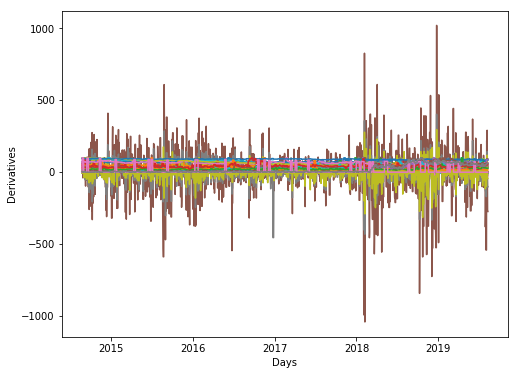

(1814, 38)

In [10]:
plot_dataset(dataset)
dataset.shape

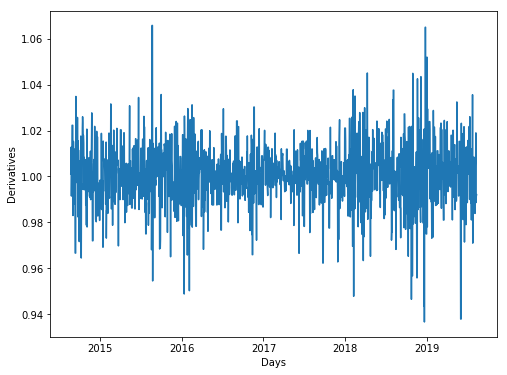

1814

In [11]:
plot_dataset(ticker_y)
ticker_y.size

In [12]:
# Ground truth.
dataset['y'] = (ticker_y > (1.0 + (gain / 2.0))).astype(int)
print('Percentage of ones (keep less than 5%):', 
      count_nonzero(dataset.y) / ticker_y.size)

Percentage of ones (keep less than 5%): 0.019845644983461964


In [0]:
dataset = dataset.reset_index()

In [14]:
print('Before shifting.')
dataset

Before shifting.


,Date,FB,GE,ADS,INTC,AAPL,NVDA,CSCO,AMD,AMZN,GOOG,MSFT,S,BAC,XLNX,WFC,^DJI,^GSPC,^NYA,^IXIC,FB_trend,GE_trend,ADS_trend,INTC_trend,AAPL_trend,NVDA_trend,CSCO_trend,AMD_trend,AMZN_trend,GOOG_trend,MSFT_trend,S_trend,BAC_trend,XLNX_trend,WFC_trend,^DJI_trend,^GSPC_trend,^NYA_trend,^IXIC_trend,y
0,2014-08-24,0.079994,0.048079,-1.350006,-0.279999,-0.250000,-0.049999,0.000000,-0.090000,0.809998,-4.507568,-0.230003,0.02,0.020000,-0.820000,-0.029999,65.058594,6.180054,28.620117,-6.370117,98.0,74.0,49.0,30.0,44.0,6.0,23.0,72.0,9.0,96.0,18.0,95.0,23.0,12.0,35.0,4.0,4.0,0.0,4.0,0
1,2014-08-25,0.079994,0.048079,-1.350006,-0.279999,-0.250000,-0.049999,0.000000,-0.090000,0.809998,-4.507568,-0.230003,0.02,0.020000,-0.820000,-0.029999,65.058594,6.180054,28.620117,-6.370117,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0,0
2,2014-08-26,0.959999,-0.201923,0.270020,0.009998,-0.529999,0.290001,0.109999,0.020000,4.829987,-3.390686,-0.300003,0.19,-0.010000,-0.050003,-0.009998,27.128906,1.430054,8.940430,6.830078,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0,0
3,2014-08-27,-0.639999,0.076923,-1.080017,-0.099998,1.110001,-0.100000,0.009998,-0.040000,1.089996,-6.252869,-0.030003,-0.11,-0.170000,-0.200001,-0.310001,10.980469,-0.420044,-4.230469,-4.729980,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0,0
4,2014-08-28,-0.139999,-0.019232,0.700012,0.040001,0.660004,0.199999,0.150000,0.000000,0.019989,-0.359009,0.130001,0.01,-0.090000,0.070000,-0.059998,-39.490234,-0.680054,9.959961,5.150391,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0,0
5,2014-08-29,0.519997,-0.048077,-0.489990,0.109997,-0.360001,-0.009998,0.090000,0.020000,-2.720001,0.269287,0.340000,-0.07,0.040001,0.320000,0.169998,15.029297,4.920044,22.490234,8.510254,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0,0
6,2014-08-30,1.669998,-0.038460,-0.100006,-0.189999,0.240005,0.000000,-0.060001,0.000000,2.399994,5.464966,-0.340000,-0.11,0.130001,-0.400002,-0.139999,-29.859375,-1.789917,-12.450195,5.770020,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0,0
7,2014-08-31,1.669998,-0.038460,-0.100006,-0.189999,0.240005,0.000000,-0.060001,0.000000,2.399994,5.464966,-0.340000,-0.11,0.130001,-0.400002,-0.139999,-29.859375,-1.789917,-12.450195,5.770020,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0,0
8,2014-09-01,1.669998,-0.038460,-0.100006,-0.189999,0.240005,0.000000,-0.060001,0.000000,2.399994,5.464966,-0.340000,-0.11,0.130001,-0.400002,-0.139999,-29.859375,-1.789917,-12.450195,5.770020,93.0,76.0,52.0,27.0,100.0,6.0,28.0,73.0,7.0,100.0,22.0,96.0,22.0,16.0,35.0,2.0,8.0,0.0,4.0,0
9,2014-09-02,1.669998,-0.038460,-0.100006,-0.189999,0.240005,0.000000,-0.060001,0.000000,2.399994,5.464966,-0.340000,-0.11,0.130001,-0.400002,-0.139999,-29.859375,-1.789917,-12.450195,5.770020,93.0,76.0,52.0,27.0,100.0,6.0,28.0,73.0,7.0,100.0,22.0,96.0,22.0,16.0,35.0,2.0,8.0,0.0,4.0,0


In [15]:
print('After shifting.')
dataset = curve_shift(dataset, shift_by=-1)
dataset

After shifting.


,y,Date,FB,GE,ADS,INTC,AAPL,NVDA,CSCO,AMD,AMZN,GOOG,MSFT,S,BAC,XLNX,WFC,^DJI,^GSPC,^NYA,^IXIC,FB_trend,GE_trend,ADS_trend,INTC_trend,AAPL_trend,NVDA_trend,CSCO_trend,AMD_trend,AMZN_trend,GOOG_trend,MSFT_trend,S_trend,BAC_trend,XLNX_trend,WFC_trend,^DJI_trend,^GSPC_trend,^NYA_trend,^IXIC_trend
0,0.0,2014-08-24,0.079994,0.048079,-1.350006,-0.279999,-0.250000,-0.049999,0.000000,-0.090000,0.809998,-4.507568,-0.230003,0.02,0.020000,-0.820000,-0.029999,65.058594,6.180054,28.620117,-6.370117,98.0,74.0,49.0,30.0,44.0,6.0,23.0,72.0,9.0,96.0,18.0,95.0,23.0,12.0,35.0,4.0,4.0,0.0,4.0
1,0.0,2014-08-25,0.079994,0.048079,-1.350006,-0.279999,-0.250000,-0.049999,0.000000,-0.090000,0.809998,-4.507568,-0.230003,0.02,0.020000,-0.820000,-0.029999,65.058594,6.180054,28.620117,-6.370117,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0
2,0.0,2014-08-26,0.959999,-0.201923,0.270020,0.009998,-0.529999,0.290001,0.109999,0.020000,4.829987,-3.390686,-0.300003,0.19,-0.010000,-0.050003,-0.009998,27.128906,1.430054,8.940430,6.830078,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0
3,0.0,2014-08-27,-0.639999,0.076923,-1.080017,-0.099998,1.110001,-0.100000,0.009998,-0.040000,1.089996,-6.252869,-0.030003,-0.11,-0.170000,-0.200001,-0.310001,10.980469,-0.420044,-4.230469,-4.729980,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0
4,0.0,2014-08-28,-0.139999,-0.019232,0.700012,0.040001,0.660004,0.199999,0.150000,0.000000,0.019989,-0.359009,0.130001,0.01,-0.090000,0.070000,-0.059998,-39.490234,-0.680054,9.959961,5.150391,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0
5,0.0,2014-08-29,0.519997,-0.048077,-0.489990,0.109997,-0.360001,-0.009998,0.090000,0.020000,-2.720001,0.269287,0.340000,-0.07,0.040001,0.320000,0.169998,15.029297,4.920044,22.490234,8.510254,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0
6,0.0,2014-08-30,1.669998,-0.038460,-0.100006,-0.189999,0.240005,0.000000,-0.060001,0.000000,2.399994,5.464966,-0.340000,-0.11,0.130001,-0.400002,-0.139999,-29.859375,-1.789917,-12.450195,5.770020,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0
7,0.0,2014-08-31,1.669998,-0.038460,-0.100006,-0.189999,0.240005,0.000000,-0.060001,0.000000,2.399994,5.464966,-0.340000,-0.11,0.130001,-0.400002,-0.139999,-29.859375,-1.789917,-12.450195,5.770020,96.0,75.0,49.0,26.0,55.0,7.0,21.0,70.0,6.0,100.0,18.0,96.0,24.0,20.0,31.0,3.0,6.0,100.0,0.0
8,0.0,2014-09-01,1.669998,-0.038460,-0.100006,-0.189999,0.240005,0.000000,-0.060001,0.000000,2.399994,5.464966,-0.340000,-0.11,0.130001,-0.400002,-0.139999,-29.859375,-1.789917,-12.450195,5.770020,93.0,76.0,52.0,27.0,100.0,6.0,28.0,73.0,7.0,100.0,22.0,96.0,22.0,16.0,35.0,2.0,8.0,0.0,4.0
9,0.0,2014-09-02,1.669998,-0.038460,-0.100006,-0.189999,0.240005,0.000000,-0.060001,0.000000,2.399994,5.464966,-0.340000,-0.11,0.130001,-0.400002,-0.139999,-29.859375,-1.789917,-12.450195,5.770020,93.0,76.0,52.0,27.0,100.0,6.0,28.0,73.0,7.0,100.0,22.0,96.0,22.0,16.0,35.0,2.0,8.0,0.0,4.0


In [0]:
dataset = dataset.drop(columns=['Date'])

In [0]:
# Converts the DataFrame to a numpy array.
input_X = dataset.loc[:,dataset.columns != 'y'].values
input_y = dataset['y'].values

# Number of features.
n_features = input_X.shape[1]

In [18]:
# Test: The 3D tensors (arrays) for LSTM are forming correctly.
print('First instance of y = 1 in the original data.')
display(dataset.iloc[(where(array(input_y) == 1)[0][0] - lookback):(where(array(input_y) == 1)[0][0] + 1),])

# Temporalize the data.
X, y = temporalize(X=input_X, y=input_y, lookback=lookback)

print('For the same instance of y=1, we are keeping past 5 samples in the 3D predictor array, X.')
display(DataFrame(concatenate(X[where(array(y) == 1)[0][0]], axis=0)))

First instance of y = 1 in the original data.


,y,FB,GE,ADS,INTC,AAPL,NVDA,CSCO,AMD,AMZN,GOOG,MSFT,S,BAC,XLNX,WFC,^DJI,^GSPC,^NYA,^IXIC,FB_trend,GE_trend,ADS_trend,INTC_trend,AAPL_trend,NVDA_trend,CSCO_trend,AMD_trend,AMZN_trend,GOOG_trend,MSFT_trend,S_trend,BAC_trend,XLNX_trend,WFC_trend,^DJI_trend,^GSPC_trend,^NYA_trend,^IXIC_trend
17,0.0,0.910004,-0.038462,13.709991,0.170002,2.989998,-0.039999,0.090000,0.00,-2.970001,1.595642,0.020000,0.34,0.200001,0.139999,0.439999,52.660156,7.279907,25.509766,32.370117,94.0,75.0,52.0,25.0,58.0,6.0,26.0,70.0,6.0,100.0,24.0,94.0,22.0,18.0,32.0,2.0,16.0,0.0,0.0
18,0.0,0.790001,0.105768,-5.580017,0.230000,1.019997,-0.059999,0.260000,0.05,0.579987,0.987305,0.259998,0.50,0.250000,0.010002,0.189999,-8.410156,4.599976,42.620117,24.169922,94.0,75.0,52.0,25.0,58.0,6.0,26.0,70.0,6.0,100.0,24.0,94.0,22.0,18.0,32.0,2.0,16.0,0.0,0.0
19,0.0,-0.539993,-0.096153,-1.949982,-0.280003,0.450005,-0.410000,0.000000,-0.10,1.630005,-5.365295,-0.209999,0.13,0.170000,-0.360001,0.030003,-56.541016,-11.199951,-53.930664,-21.169922,94.0,75.0,52.0,25.0,58.0,6.0,26.0,70.0,6.0,100.0,24.0,94.0,22.0,18.0,32.0,2.0,16.0,0.0,0.0
20,0.0,-2.570000,0.086538,-5.860016,-0.169998,-1.180000,-0.320000,0.109999,-0.07,-7.019989,0.159607,-0.299999,-0.09,-0.059999,-0.539997,0.209999,42.380859,-1.910034,-0.540039,-48.550293,94.0,75.0,52.0,25.0,58.0,6.0,26.0,70.0,6.0,100.0,24.0,94.0,22.0,18.0,32.0,2.0,16.0,0.0,0.0
21,0.0,-2.570000,0.086538,-5.860016,-0.169998,-1.180000,-0.320000,0.109999,-0.07,-7.019989,0.159607,-0.299999,-0.09,-0.059999,-0.539997,0.209999,42.380859,-1.910034,-0.540039,-48.550293,94.0,75.0,52.0,25.0,58.0,6.0,26.0,70.0,6.0,100.0,24.0,94.0,22.0,18.0,32.0,2.0,16.0,0.0,0.0
22,1.0,-2.570000,0.086538,-5.860016,-0.169998,-1.180000,-0.320000,0.109999,-0.07,-7.019989,0.159607,-0.299999,-0.09,-0.059999,-0.539997,0.209999,42.380859,-1.910034,-0.540039,-48.550293,90.0,72.0,51.0,20.0,57.0,5.0,24.0,68.0,5.0,100.0,20.0,94.0,22.0,20.0,29.0,5.0,0.0,98.0,0.0


For the same instance of y=1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,0.790001,0.105768,-5.580017,0.230000,1.019997,-0.059999,0.260000,0.05,0.579987,0.987305,0.259998,0.50,0.250000,0.010002,0.189999,-8.410156,4.599976,42.620117,24.169922,94.0,75.0,52.0,25.0,58.0,6.0,26.0,70.0,6.0,100.0,24.0,94.0,22.0,18.0,32.0,2.0,16.0,0.0,0.0
1,-0.539993,-0.096153,-1.949982,-0.280003,0.450005,-0.410000,0.000000,-0.10,1.630005,-5.365295,-0.209999,0.13,0.170000,-0.360001,0.030003,-56.541016,-11.199951,-53.930664,-21.169922,94.0,75.0,52.0,25.0,58.0,6.0,26.0,70.0,6.0,100.0,24.0,94.0,22.0,18.0,32.0,2.0,16.0,0.0,0.0
2,-2.570000,0.086538,-5.860016,-0.169998,-1.180000,-0.320000,0.109999,-0.07,-7.019989,0.159607,-0.299999,-0.09,-0.059999,-0.539997,0.209999,42.380859,-1.910034,-0.540039,-48.550293,94.0,75.0,52.0,25.0,58.0,6.0,26.0,70.0,6.0,100.0,24.0,94.0,22.0,18.0,32.0,2.0,16.0,0.0,0.0
3,-2.570000,0.086538,-5.860016,-0.169998,-1.180000,-0.320000,0.109999,-0.07,-7.019989,0.159607,-0.299999,-0.09,-0.059999,-0.539997,0.209999,42.380859,-1.910034,-0.540039,-48.550293,94.0,75.0,52.0,25.0,58.0,6.0,26.0,70.0,6.0,100.0,24.0,94.0,22.0,18.0,32.0,2.0,16.0,0.0,0.0
4,-2.570000,0.086538,-5.860016,-0.169998,-1.180000,-0.320000,0.109999,-0.07,-7.019989,0.159607,-0.299999,-0.09,-0.059999,-0.539997,0.209999,42.380859,-1.910034,-0.540039,-48.550293,90.0,72.0,51.0,20.0,57.0,5.0,24.0,68.0,5.0,100.0,20.0,94.0,22.0,20.0,29.0,5.0,0.0,98.0,0.0


The two tables are the same. This testifies that we are correctly taking 5 samples (= lookback), X(t):X(t-5) to predict y(t).

In [0]:
X_train, X_test, y_train, y_test = train_test_split(array(X), array(y), test_size=test_size, random_state=random_seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=random_seed)

In [0]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]
X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [21]:
X_train.shape

(1133, 5, 1, 38)

In [22]:
X_train_y0.shape

(1112, 5, 1, 38)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [0]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

In [0]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [25]:
# Test scaling validity.
a = flatten(X_train_y0_scaled)
print('Column-wise mean (should be all zeros):', mean(a, axis=0).round(6))
print('Column-wise variance (should be all ones):', var(a, axis=0))

Column-wise mean (should be all zeros): [-0.  0.  0.  0.  0. -0. -0. -0.  0. -0. -0. -0.  0. -0.  0. -0. -0. -0.
 -0. -0.  0.  0. -0.  0.  0.  0. -0. -0.  0.  0. -0.  0.  0.  0. -0. -0.
  0. -0.]
Column-wise variance (should be all ones): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
# Scale test and validation sets.
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)
X_test_scaled = scale(X_test, scaler)

## LSTM Autoencoder training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [0]:
timesteps =  X_train_y0_scaled.shape[1] # Equal to the lookback.
n_features =  X_train_y0_scaled.shape[2] # 59.

In [28]:
LSTM_autoencoder = Sequential()
# Encoder.
LSTM_autoencoder.add(LSTM(units=32, 
                          activation='relu', 
                          input_shape=(timesteps, n_features), 
                          return_sequences=True))

LSTM_autoencoder.add(LSTM(units=16, activation='relu', return_sequences=False))
LSTM_autoencoder.add(RepeatVector(timesteps))
# Decoder.
LSTM_autoencoder.add(LSTM(units=16, activation='relu', return_sequences=True))
LSTM_autoencoder.add(LSTM(units=32, activation='relu', return_sequences=True))
LSTM_autoencoder.add(TimeDistributed(Dense(n_features)))

# Keep parameters less than non-droped out features.
LSTM_autoencoder.summary()

W0818 04:24:30.079383 139830331914112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 04:24:30.082807 139830331914112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 04:24:30.098629 139830331914112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 32)             9088      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 38)             1254      
Total params: 21,862
Trainable params: 21,862
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Path to model weights (saved periodically).
filepath = path + 'LSTM_autoencoder.h5'

# Gradient descent optimization.
optimizer = Adam(lr=learning_rate, clipnorm=1., clipvalue=0.5)

# Training configuration.
LSTM_autoencoder.compile(loss='mean_squared_error', optimizer=optimizer)

# Save model weights after each epoch if validation loss decreased.
checkpointer = ModelCheckpoint(filepath=filepath, 
                               save_best_only=True, 
                               verbose=1)

# Control learning rate schedule when validation is not improving.
reduce_lr = ReduceLROnPlateau(factor=0.1, 
                              patience=patience, 
                              verbose=1, 
                              min_lr=learning_rate / 1000)

# Various graphics.
tbc = TensorBoardColab()

# Shouldn't happen.
term_on_NaN = TerminateOnNaN()

history = LSTM_autoencoder.fit(X_train_y0_scaled, 
                               X_train_y0_scaled, 
                               epochs=epochs, 
                               batch_size=batch_size, 
                               validation_data=(X_valid_y0_scaled, 
                                                X_valid_y0_scaled), 
                               callbacks=[checkpointer, 
                                          reduce_lr, 
                                          TensorBoardColabCallback(tbc), 
                                          term_on_NaN], 
                                          verbose=1).history

W0818 04:24:31.129065 139830331914112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Wait for 8 seconds...
TensorBoard link:
https://9aa16bfd.ngrok.io


W0818 04:24:49.733074 139830331914112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0818 04:24:52.739177 139830331914112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0818 04:24:52.942743 139830331914112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0818 04:24:53.153205 139830331914112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter i

Train on 1112 samples, validate on 280 samples


W0818 04:24:53.823594 139830331914112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Epoch 1/200
1112/1112 [==============================] - 4s 3ms/step - loss: 1.0119 - val_loss: 0.9644

Epoch 00001: val_loss improved from inf to 0.96437, saving model to /content/gdrive/My Drive/LSTM_autoencoder/LSTM_autoencoder.h5
Epoch 2/200
1112/1112 [==============================] - 1s 607us/step - loss: 1.0116 - val_loss: 0.9641

Epoch 00002: val_loss improved from 0.96437 to 0.96406, saving model to /content/gdrive/My Drive/LSTM_autoencoder/LSTM_autoencoder.h5
Epoch 3/200
1112/1112 [==============================] - 1s 605us/step - loss: 1.0112 - val_loss: 0.9637

Epoch 00003: val_loss improved from 0.96406 to 0.96366, saving model to /content/gdrive/My Drive/LSTM_autoencoder/LSTM_autoencoder.h5
Epoch 4/200
1112/1112 [==============================] - 1s 602us/step - loss: 1.0107 - val_loss: 0.9629

Epoch 00004: val_loss improved from 0.96366 to 0.96295, saving model to /content/gdrive/My Drive/LSTM_autoencoder/LSTM_autoencoder.h5
Epoch 5/200
1112/1112 [=======================

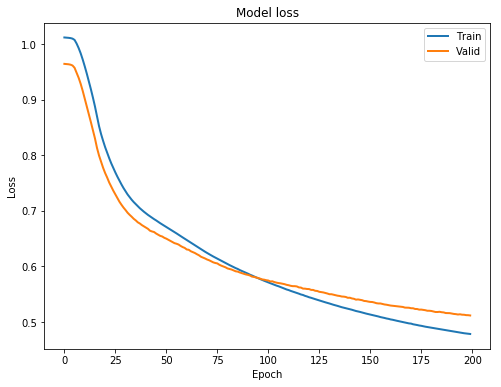

In [30]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Reconstruction error should be less than one.


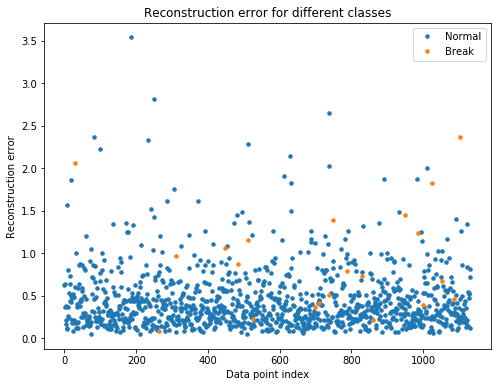

In [31]:
print('Reconstruction error should be less than one.')

train_x_predictions = LSTM_autoencoder.predict(X_train_scaled)
mse = mean(power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), 
           axis=1)

error = DataFrame({'Reconstruction_error': mse, 'True_class': y_train.tolist()})

groups = error.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, 
            group.Reconstruction_error, 
            marker='o', 
            ms=3.5, 
            linestyle='',
            label = 'Break' if name == 1 else 'Normal')
ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show();

## Predictions using the Autoencoder

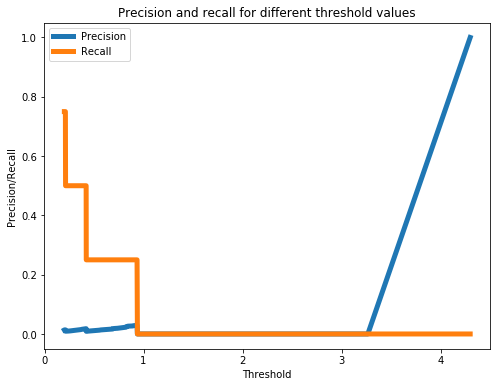

In [32]:
valid_x_predictions = LSTM_autoencoder.predict(X_valid_scaled)
mse = mean(power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), 
           axis=1)

error = DataFrame({'Reconstruction_error': mse, 'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error.True_class, 
                                                               error.Reconstruction_error)

plt.plot(threshold_rt, precision_rt[1:], label='Precision', linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label='Recall', linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

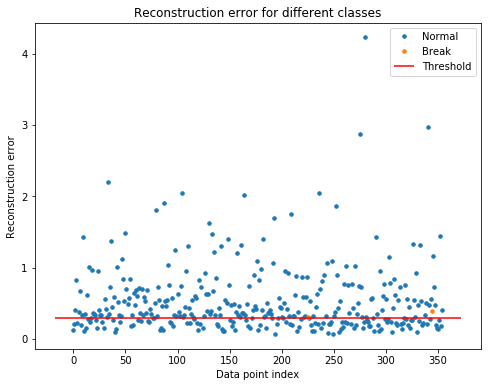

In [33]:
test_x_predictions = LSTM_autoencoder.predict(X_test_scaled)
mse = mean(power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), 
           axis=1)

error = DataFrame({'Reconstruction_error': mse, 'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, 
            group.Reconstruction_error, 
            marker='o', 
            ms=3.5, 
            linestyle='',
            label= 'Break' if name == 1 else 'Normal')

ax.hlines(threshold_fixed, 
          ax.get_xlim()[0], 
          ax.get_xlim()[1], 
          colors='r', 
          zorder=100, 
          label='Threshold')

ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show();

In [0]:
pred_y = [1 if e > threshold_fixed else 0 for e in error.Reconstruction_error.values]
conf_matrix = confusion_matrix(error.True_class, pred_y)

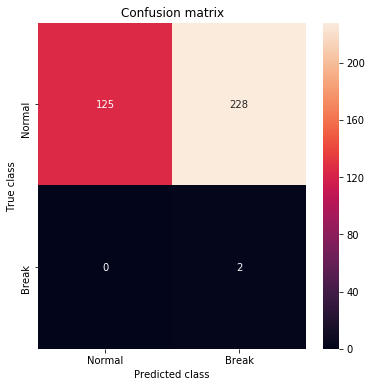

In [35]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, 
            xticklabels=labels, 
            yticklabels=labels, 
            annot=True, 
            fmt='d');

plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [0]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error.True_class, 
                                                      error.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

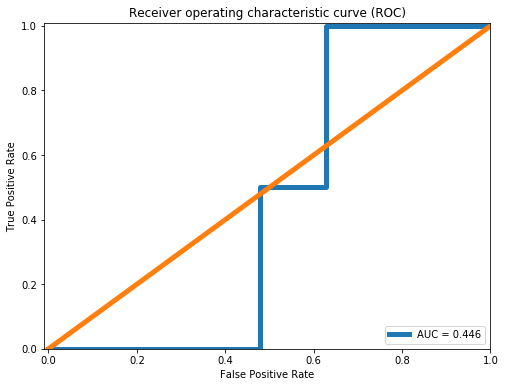

In [37]:
plt.plot(false_pos_rate, 
         true_pos_rate, 
         linewidth=5, 
         label='AUC = ' + str(round(roc_auc, 3)))
plt.plot([0, 1], [0, 1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()